# Reading data from database

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
from sqlalchemy import create_engine

In [2]:
user = "postgres"
password = "123123"
db_name = "chinook"
hostname = "localhost"
connection_string = f"postgresql+psycopg2://{user}:{password}@{hostname}/{db_name}"
engine = create_engine(connection_string)

In [3]:
with engine.connect() as conn:
    dim_track = pd.read_sql_table('dim_track',conn,schema='dwh')
    dim_playlist = pd.read_sql_table('dim_playlist',conn,schema='dwh')
    dim_currency = pd.read_sql_table('dim_currency',conn,schema='dwh')
    dim_customer = pd.read_sql_table('dim_customer',conn,schema='dwh')
    dim_employee = pd.read_sql_table('dim_employee',conn,schema='dwh')
    fact_invoice = pd.read_sql_table('fact_invoice',conn,schema='dwh')
    fact_invoiceline = pd.read_sql_table('fact_invoiceline',conn,schema='dwh')

# Analysis of Artist & Tracks

- Most albums
- Most tracks in album
- Most tracks in genre

At first we will look at the `head` rows to understand how we will

group the information and analyze it.

In [4]:
dim_track.head()

,trackid,name,albumid,mediatypeid,genreid,artistid,unitprice,album_title,artist_name,media_name,genre_name,seconds,length
0,1,For Those About To Rock (We Salute You),1,1,1,1,0.99,For Those About To Rock We Salute You,AC/DC,MPEG audio file,Rock,343,05:43
1,2,Balls to the Wall,2,2,1,2,0.99,Balls to the Wall,Accept,Protected AAC audio file,Rock,342,05:42
2,3,Fast As a Shark,3,2,1,2,0.99,Restless and Wild,Accept,Protected AAC audio file,Rock,230,03:50
3,4,Restless and Wild,3,2,1,2,0.99,Restless and Wild,Accept,Protected AAC audio file,Rock,252,04:12
4,5,Princess of the Dawn,3,2,1,2,0.99,Restless and Wild,Accept,Protected AAC audio file,Rock,375,06:15


From the results above we can understnad that we need to group by ethier

`artist_name` and `genre_name` for the "Most tracks in genre"

In [5]:
# starting by grouping by artist_name and count the amount of unique albums.
most_albums = dim_track.groupby("artist_name")['albumid'].nunique().sort_values(ascending=False).head(5)
most_albums

artist_name
Iron Maiden     21
Led Zeppelin    14
Deep Purple     11
Metallica       10
U2              10
Name: albumid, dtype: int64

In [6]:
# Moving on to count the amount of tracks by the same grouping as above.
most_tracks = dim_track.groupby("artist_name")['trackid'].nunique().sort_values(ascending=False).head(5)
most_tracks

artist_name
Iron Maiden     213
U2              135
Led Zeppelin    114
Metallica       112
Deep Purple      92
Name: trackid, dtype: int64

In [7]:
# Last one need to group by genre_name to count the amount of tracks in each one.
# Remember we only need the unique tracks.
most_tracks_genre = dim_track.groupby("genre_name")['trackid'].nunique().sort_values(ascending=False).head(5)
most_tracks_genre

genre_name
Rock                  1297
Latin                  579
Metal                  374
Alternative & Punk     332
Jazz                   130
Name: trackid, dtype: int64

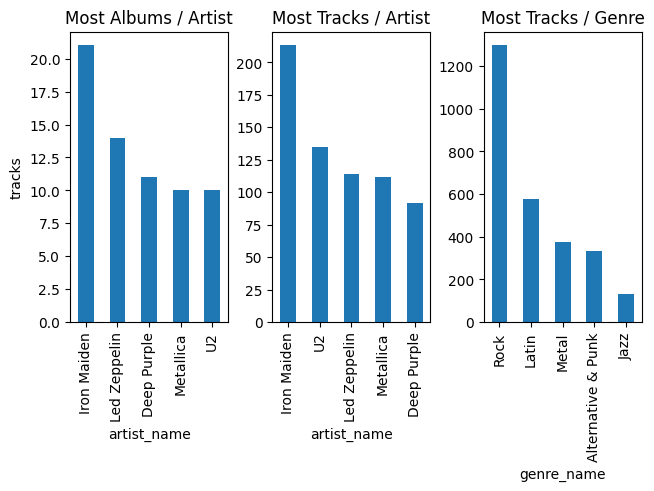

In [8]:
# Now we got to the visual part of analyzing the data.
# create the axes for all the plots
# layout="constrained" will fix the clamping of figures.
fig,axes =  plt.subplots(nrows=1,ncols=3,sharex=False,sharey=False,layout="constrained")
axes[0].set_ylabel('tracks')
most_albums.plot(kind='bar',ax=axes[0],title="Most Albums / Artist")
most_tracks.plot(kind='bar',ax=axes[1],title="Most Tracks / Artist")
most_tracks_genre.plot(kind='bar',ax=axes[2],title="Most Tracks / Genre");

---

# Find the customer which generates most revenue

We have to find out the customers who generated the most revenue

to the company by both dollar and ILS.

## Problem

ILS always changes according to the dollar so we have to append the ILS

amount of each invoice according to the date and only then calculate it.

In [9]:
# Looking over the data to understand the table and how to analyze it.
fact_invoice.head()

,invoiceid,customerid,invoicedate,billingcountry,total
0,1,2,2018-01-01,Germany,1.98
1,2,4,2018-01-02,Norway,3.96
2,3,8,2018-01-03,Belgium,5.94
3,4,14,2018-01-06,Canada,8.91
4,5,23,2018-01-11,USA,13.86


In [10]:
# merge the invoice and currency tables in the data warehouse schema and only get the values needed.
data = pd.merge(left=fact_invoice,right=dim_currency,left_on="invoicedate",right_on="dates",how='left')[['customerid','total','ils_value']]
data = data.rename(columns={"total":"total_dollars"}) # rename to total_dollars to clarify.
data['total_ils'] = data['total_dollars'] * data['ils_value']

In [11]:
# Get the highest revenue customers
# We asscend by total_dollars because it will always be worth more than the ILS.
most_revenue_customers = data.groupby('customerid')[['total_dollars','total_ils']].agg('sum').sort_values(ascending=False,by=['total_dollars']).reset_index()
most_revenue_customers = most_revenue_customers.head(5) # Get only the top 5 most revenue.

In [12]:
# Merge the resulst above with customers table to get their names
most_revenue_customers = most_revenue_customers.merge(dim_customer[['customerid','firstname','lastname']],on='customerid', how='left')
# Better view with full name rather than firstname and lastname
most_revenue_customers['fullname'] = most_revenue_customers['firstname'] + ' ' + most_revenue_customers['lastname'] 
# Get only the data which is needed.
most_revenue_customers = most_revenue_customers[['customerid','total_dollars','total_ils','fullname']]
most_revenue_customers

,customerid,total_dollars,total_ils,fullname
0,59,71.31,246.01959,Puja Srivastava
1,132,65.36,226.88945,Denise Kelly
2,179,55.44,185.51016,Josephine Gomez
3,6,49.62,172.56861,Helena Holý
4,26,47.62,157.98583,Richard Cunningham


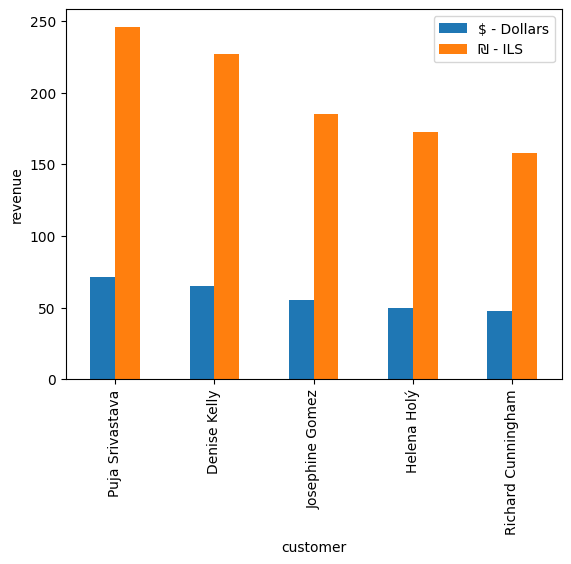

In [13]:
# plot to dollars and ILS
most_revenue_customers.plot(kind='bar',x='fullname',y=['total_dollars','total_ils'])
# More readable labels and add legend.
plt.ylabel('revenue')
plt.xlabel('customer')
plt.legend(['$ - Dollars','₪ - ILS'])

---

# Analyze monthly revenue trends yearly

In [14]:
# Add the year and month to each column
fact_invoice['year'] = fact_invoice.invoicedate.dt.year
fact_invoice['month'] = fact_invoice.invoicedate.dt.month
# Check that the data created succesfully.
fact_invoice.head(1)

,invoiceid,customerid,invoicedate,billingcountry,total,year,month
0,1,2,2018-01-01,Germany,1.98,2018,1


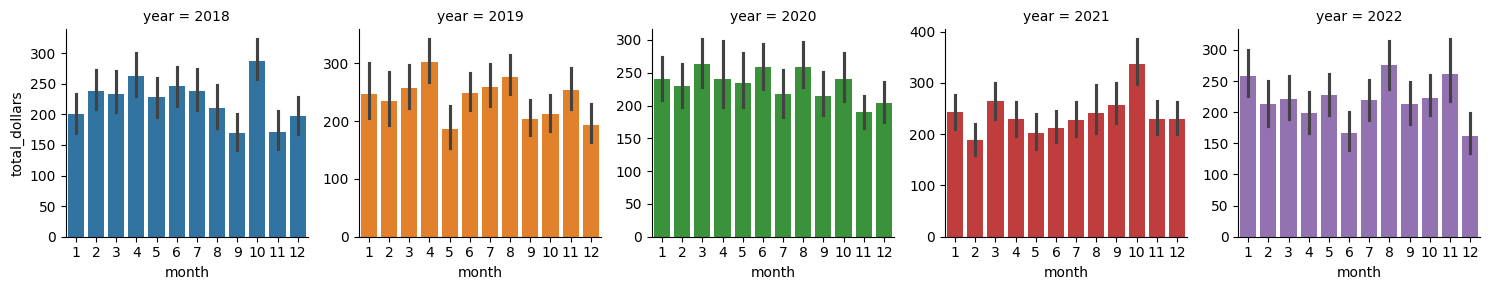

In [15]:
# Create facet grid in order to display all of the plots one next to the other.
grid = sns.FacetGrid(fact_invoice,col='year',hue='year',sharex=False,sharey=False)
# make sure that months are ordered correctly.
month_order = list(range(1,13))
grid.map(sns.barplot,'month','total',estimator='sum',order=month_order)
# change the y label to be total_dollars instead of just total.
grid.set_axis_labels(y_var="total_dollars");

---

# Correlation between price and length

To find if there is a correlation between the price and length

we will need to divide all the tracks into bins and then look over

the visual data.

After dividing all of the tracks to bins we can look over the average

unitprice of the tracks based on their bins.

In [16]:
# divide all of the tracks to bins
dim_tracks_bins = dim_track.copy()
bins = ['short','medium','long']
dim_tracks_bins['bin'] = pd.cut(dim_track['seconds'],bins=3,labels=bins)

<Axes: xlabel='bin', ylabel='unitprice'>

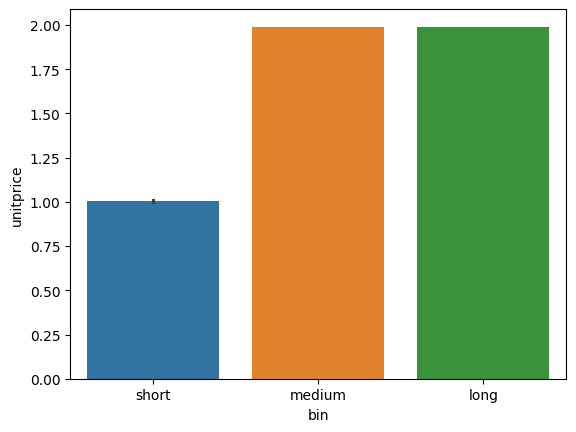

In [17]:
# plot the data to look at it visually.
sns.barplot(dim_tracks_bins,x='bin',y='unitprice',hue='bin',estimator='mean')

## Conclusions

After dividing the tracks into bins of `short`, `medium` and `long`, we looked over

the **average** unitprice for each bin over a visual bar chart.

On the bar chart above we can see that **medium** and **long** tracks will
usually set for **1.99 dollars**.

On the other hand tracks that are short will be priced
at **0.99 dollar**.

**Therefor** there is a correlation between the length of the track and its price.

The higher the length of the track the more expensive it will be.

---

# Tracks Recommendation

The customer need to get a recommendation for 6 tracks.

## Conditions
- The customer haven't buy the track yet.
- It need's to be from 2 geners the the customer provide.

Let's look over the tables data to understand how can I correlate between them.

In [18]:
fact_invoice.head(1)

,invoiceid,customerid,invoicedate,billingcountry,total,year,month
0,1,2,2018-01-01,Germany,1.98,2018,1


In [19]:
fact_invoiceline.head(1)

,invoicelineid,invoiceid,trackid,unitprice,quantity,last_update,line_total
0,1,1,2,0.99,1,2023-01-04 12:05:45.793418,0.99


In [20]:
dim_track.head(1)

,trackid,name,albumid,mediatypeid,genreid,artistid,unitprice,album_title,artist_name,media_name,genre_name,seconds,length
0,1,For Those About To Rock (We Salute You),1,1,1,1,0.99,For Those About To Rock We Salute You,AC/DC,MPEG audio file,Rock,343,05:43


In [21]:
def get_recommendation(customer_id,genre_list):
    """
    The functions takes it
    customer_id - the customer_id
    genre_list - a list object with 2 values in it which represent 
                 the genres that the user want to get recommendation to.
    """
    # Get data of tracks and customer tracks purchesed list
    data = pd.merge(fact_invoiceline,fact_invoice, on='invoiceid',how='left').merge(dim_track,on='trackid',how='left')
    # Find out which tracks are the most popular 
    df_recomendation = data.groupby(['genre_name','trackid','name'])['invoicelineid'].count().reset_index(name='total_buy').sort_values(['genre_name', 'total_buy'],ascending=[True,False])
    df_customer = data[(data['customerid'] == customer_id) & (data['genre_name'].isin(genre_list))][['customerid','trackid','genre_name']]
    # Remove all the tracks which the user bought
    df = df_recomendation[~df_recomendation['trackid'].isin(df_customer['trackid'])]
    # Find the top 3 tracks for the genre
    df = df.groupby('genre_name')[['genre_name','trackid','total_buy','name']].apply(lambda x: x.nlargest(3,'total_buy')).reset_index(drop=True)
    # pretify the data frame for the user. Included the trackid for the user to find quicker.
    df = df[df['genre_name'].isin(genre_list)].reset_index(drop=True)[['genre_name','name','trackid']]
    return df

In [22]:
# Proof of recomendation working.
test_results = pd.merge(fact_invoice[fact_invoice['customerid'] == 41],fact_invoiceline, on='invoiceid',how='inner')[['customerid','trackid']]
user_41_recomendation = get_recommendation(41,['World','Latin'])

In [23]:
user_41_recomendation

,genre_name,name,trackid
0,Latin,Geni E O Zepelim,241
1,Latin,Agora Que O Dia Acordou,594
2,Latin,Chão de Giz (Elba Ramalho),663
3,World,Cafezinho,1544
4,World,Choramingando,1533
5,World,Já Foi,1964


In [24]:
user_41_recomendation['trackid'].isin(test_results['trackid'])

0    False
1    False
2    False
3    False
4    False
5    False
Name: trackid, dtype: bool

---

# My own analysis - Assessing playlist revenue contribution at the country level

## Note to self on tables, can be skipped by the reader

So the data that can be analyzed are the following:
- Invoices - can give total revenue and the amount of orders
- Invoiceline - can give more details about the invoice itself by giving the trackid
- tracks - can analysis something with the companies or bands which already has been analyzed in [here](#Analysis-of-Artist-&-Tracks)
- playlist - show more information about which songs are more commonly picked on playlists

helper tables will be:
- customers - can get the country, company, city...
- employee - can get the department and use it to analyze
- currency - if there is a need to show the total in ILS, like showed in [here](#Find-the-customer-which-generates-most-revenue)

## Assessing playlist revenue contribution at the country level

### First find out which country generates the most revenue

In [25]:
# Get the total revenue by grouping to countries.
data = fact_invoice.groupby('billingcountry')['total'].sum().reset_index(name="revenue").sort_values(by='revenue',ascending=False)
# Get the total amount of customers on each country.
customer_amount = fact_invoice.groupby('billingcountry')['customerid'].nunique().reset_index(name="total_customers")
# merge the data.
data = data.merge(customer_amount,on='billingcountry',how='left')
data

,billingcountry,revenue,total_customers
0,India,1267.59,168
1,China,898.29,139
2,United States,830.84,115
3,Brazil,735.83,81
4,Japan,564.44,85
...,...,...,...
110,Zambia,5.94,1
111,Lithuania,3.97,1
112,Bahrain,3.96,1
113,Iraq,3.96,1


We filter out countries with less than 100 dollars as they

have a significantly smaller customer base.

<Axes: xlabel='billingcountry', ylabel='revenue'>

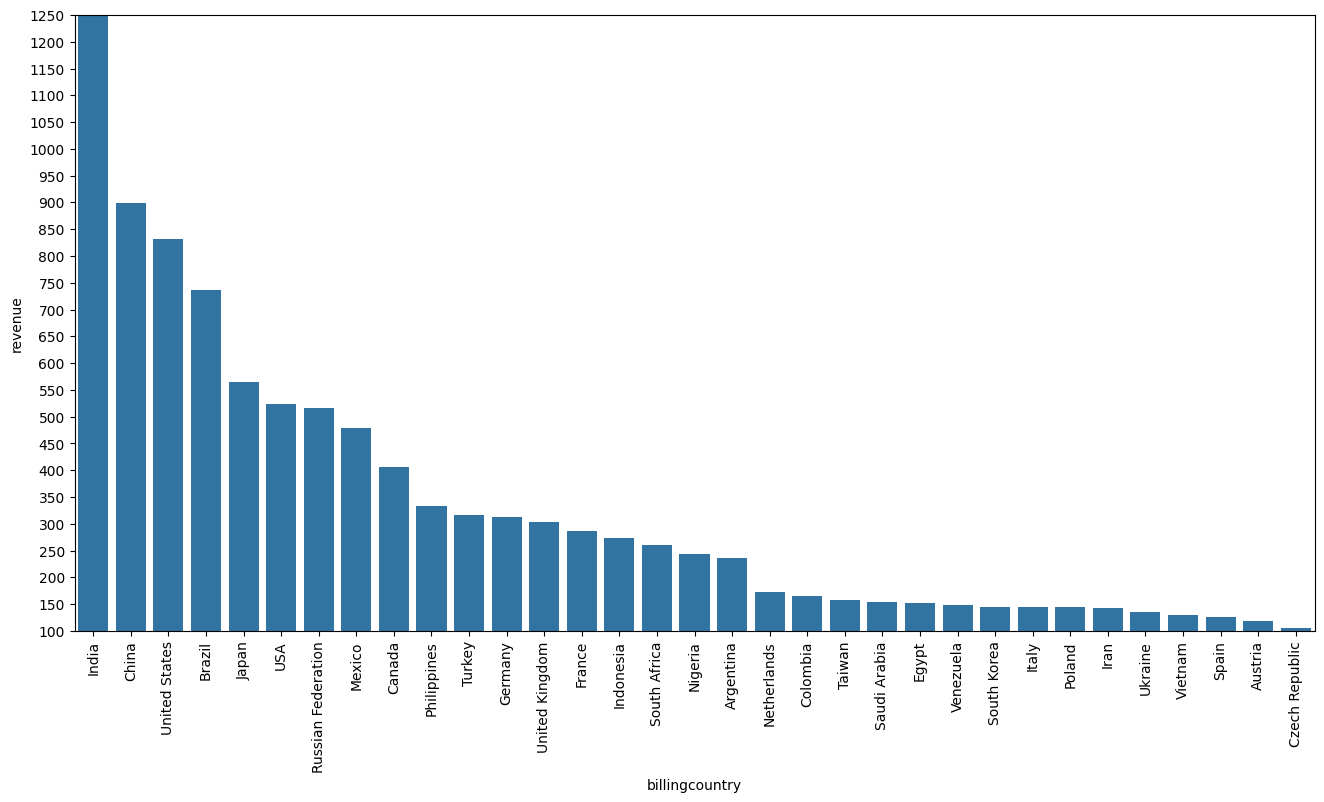

In [26]:
# Countries with low revenue are usually countries where
# there are not a lot of customers to sample so filter them out.
data = data[data['revenue'] > 100]

# plot configuration
plt.figure(figsize=(16,8))
plt.xticks(rotation=90)
plt.yticks(range(0, round(max(data["revenue"])), 50))
plt.ylim(100)

sns.barplot(data,x='billingcountry',y='revenue')

### Find the type of track which generate most revenue
After filtering the countries of most relevent revenue,<br>
we can now analyze the playlist revenue

Text(0.5, 1.0, 'Most Revenue Playlist')

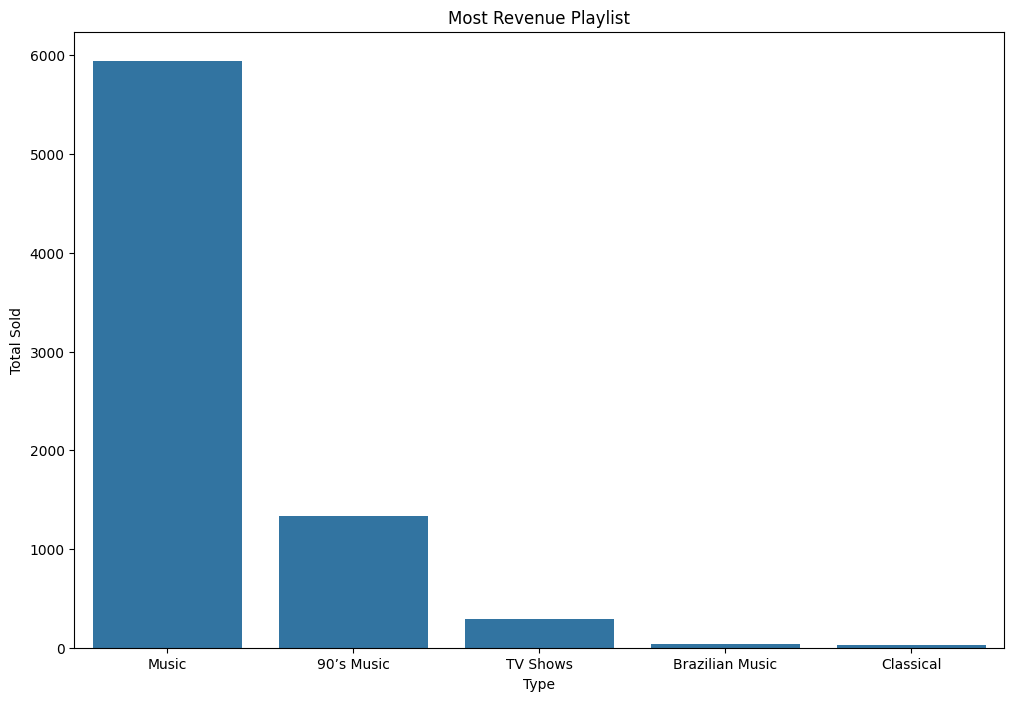

In [27]:
# get only the countries which are in our data or most revenue countries.
df_invoice_top_countries = fact_invoice[fact_invoice['billingcountry'].isin(data['billingcountry'])]['invoiceid'] 
# get tracks which are pressented on the df_invoice_top_countries
df_tracks = fact_invoiceline[fact_invoiceline['invoiceid'].isin(df_invoice_top_countries.values)] 
# Count the tracks which are sold from all of the types.
df_playlist_information = dim_playlist[dim_playlist['trackid'].isin(df_tracks['trackid'])]['name'].value_counts().reset_index(name='total_sold')


# Some plotting configuration
plt.figure(figsize=(12,8))
plt.xlabel('Type')
plt.ylabel('Total Sold')

# Display as bar plot
sns.barplot(df_playlist_information.head(5),x='name',y='total_sold').set_title("Most Revenue Playlist")

As we can see from the data above customers from the countries which have 100$ total

revenue and above, will usually buy **Music**, **90's Music** and **Tv Shows**.

Therefor when there is a new track which joined those types, send a message to all the customers. 

It is most likely that they will buy the track if he's in those types or tracks.